In [9]:
# import kagglehub
# path = kagglehub.dataset_download("divyanshrai/handwritten-signatures")
# print("Path to dataset files:", path)

import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  

seed = 1002122407
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

In [10]:
class Signature:
    def __init__(self, filepath, forged=False):
        self.filepath = filepath
        self.forged = forged
        self.resampled = None
        self.signature_of = None
        self.signature_by = None
        self.sample_no = None
        self.resample()
        self.parse_filename()

    def parse_filename(self):
        filename = os.path.basename(self.filepath)
        if filename.startswith("NFI-") and len(filename) >= 11:
            try:
                self.signature_by = int(filename[4:7])  # XXX (person who signed it)
                self.sample_no = int(filename[7:9])     # YY (sample number)
                self.signature_of = int(filename[9:12]) # ZZZ (whose signature it is)
            except ValueError:
                pass

    def resample(self):
        image = cv2.imread(self.filepath, cv2.IMREAD_GRAYSCALE)
        h, w = image.shape
        max_dim = max(h, w)
        square_image = 255 * np.ones((max_dim, max_dim), dtype=np.uint8)
        y_offset = (max_dim - h) // 2
        x_offset = (max_dim - w) // 2
        square_image[y_offset:y_offset+h, x_offset:x_offset+w] = image
        normalized_image = square_image.astype(np.float32) / 255.0
        normalized_image[normalized_image > 0.95] = 1.0 # removing page boundaries
        processed_image = (normalized_image * 255).astype(np.uint8)
        resized_image = cv2.resize(processed_image, (255, 255), interpolation=cv2.INTER_AREA)
        self.resampled = resized_image / 255.0

    def show_signature(self):
        plt.imshow(self.resampled, cmap='gray')
        plt.title(f"Signature of person {self.signature_of} done by person {self.signature_by} | {'Forged' if self.forged else 'Real'}")
        plt.axis('off')
        plt.show()

class SignatureDataset:
    def __init__(self, folderpath="sample_Signature"):
        self.folderpath = folderpath
        self.signatures = []
        self.read_signatures()

    def read_signatures(self):
        for category in ["genuine", "forged"]:
            folder = os.path.join(self.folderpath, category)
            forged_flag = category == "forged" # True/False

            for filename in os.listdir(folder):
                if filename.endswith(".png") or filename.endswith(".PNG"):
                    filepath = os.path.join(folder, filename)
                    signature = Signature(filepath, forged=forged_flag)
                    self.signatures.append(signature)

    def get_data(self):
        X = np.array([sig.resampled for sig in self.signatures]).reshape(-1, 255, 255, 1)
        y = np.array([int(sig.forged) for sig in self.signatures])
        sig_by = np.array([sig.signature_by for sig in self.signatures])
        sig_of = np.array([sig.signature_of for sig in self.signatures])
        return train_test_split(X, y, sig_by, sig_of, test_size=0.2, random_state=seed)

all_data = SignatureDataset()
X_train, X_test, y_train, y_test, sig_by_train, sig_by_test, sig_of_train, sig_of_test = all_data.get_data()

libpng warning: iCCP: known incorrect sRGB profile
[ WARN:0@583.968] global grfmt_png.cpp:695 read_chunk chunk data is too large
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
[ WARN:0@587.800] global grfmt_png.cpp:695 read_chunk chunk data is too large
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
[ WARN:0@591.337] global grf

In [11]:
def create_signature_pairs(signature_dataset):
    genuine_by_person = {}
    forged_by_person = {}
    for sig in signature_dataset.signatures:
        if sig.forged:
            forged_by_person.setdefault(sig.signature_of, []).append(sig)
        else:
            genuine_by_person.setdefault(sig.signature_of, []).append(sig)

    pairs, labels = [], []
    for person_id in genuine_by_person:
        genuines = genuine_by_person[person_id]
        forgeds = forged_by_person.get(person_id, [])

        for i in range(len(genuines)):
            for j in range(i + 1, len(genuines)):
                pairs.append((genuines[i], genuines[j]))
                labels.append(1)

        for g in genuines:
            for f in forgeds:
                pairs.append((g, f))
                labels.append(0)

    return pairs, np.array(labels)

pairs, pair_labels = create_signature_pairs(all_data)

X1 = np.array([np.expand_dims(p[0].resampled, axis=-1) for p in pairs])
X2 = np.array([np.expand_dims(p[1].resampled, axis=-1) for p in pairs])
y = pair_labels
X1_train, X1_test, X2_train, X2_test, y_train, y_test = train_test_split(X1, X2, y, test_size=0.2, random_state=seed)


In [ ]:
# Siamese Model
from tensorflow.keras.layers import Input, Lambda
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K

def build_siamese_branch():
    inp = Input(shape=(255, 255, 1))
    x = Conv2D(32, (3,3), activation='relu')(inp)
    x = MaxPooling2D((2,2))(x)
    x = Conv2D(64, (3,3), activation='relu')(x)
    x = MaxPooling2D((2,2))(x)
    x = Conv2D(128, (3,3), activation='relu')(x)
    x = MaxPooling2D((2,2))(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    return Model(inp, x, name="SiameseBranch")

branch = build_siamese_branch()
input_a = Input(shape=(255, 255, 1))
input_b = Input(shape=(255, 255, 1))

feat_a = branch(input_a)
feat_b = branch(input_b)

l1_distance = Lambda(lambda tensors: K.abs(tensors[0] - tensors[1]))([feat_a, feat_b])
out = Dense(1, activation="sigmoid")(l1_distance)

siamese_model = Model(inputs=[input_a, input_b], outputs=out)
siamese_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
siamese_model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 255, 255,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_8       │ (None, 255, 255,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ SiameseBranch       │ (None, 128)       │ 14,838,400 │ input_layer_7[0]… │
│ (Functional)        │                   │            │ input_layer_8[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_2 (Lambda)   │ (None, 128)       │          0 │ SiameseBranch[0]… │
│                     │                   │            │ SiameseBranch[1]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 1)         │        129 │ lambda_2[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 14,838,529 (56.60 MB)

 Trainable params: 14,838,529 (56.60 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
# --- Cell 5 (Siamese Training) ---
history = siamese_model.fit([X1_train, X2_train], y_train, validation_data=([X1_test, X2_test], y_test),
                            epochs=20, batch_size=16)

Epoch 1/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - accuracy: 0.6636 - loss: 0.6185 - val_accuracy: 0.7429 - val_loss: 0.4657
Epoch 2/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 109s 2s/step - accuracy: 0.7265 - loss: 0.3872 - val_accuracy: 0.9190 - val_loss: 0.2571
Epoch 3/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 104s 2s/step - accuracy: 0.9353 - loss: 0.1848 - val_accuracy: 0.9476 - val_loss: 0.3192
Epoch 4/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 101s 2s/step - accuracy: 0.9743 - loss: 0.1046 - val_accuracy: 0.9429 - val_loss: 0.2684
Epoch 5/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.9884 - loss: 0.0512 - val_accuracy: 0.9333 - val_loss: 0.3434
Epoch 6/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 99s 2s/step - accuracy: 0.9964 - loss: 0.0438 - val_accuracy: 0.9238 - val_loss: 0.3449
Epoch 7/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 107s 2s/step - accuracy: 0.9989 - loss: 0.0280 - val_accuracy: 0.9333 - val_loss: 0.3466
Epoch 8/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 106s 2s/step - accuracy: 0.9877 - loss: 0.0627 - val_accuracy: 0.9619 - val

In [15]:
# --- Cell 5.1 (Print final accuracy) ---
print(f"Final Training Accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"Final Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")


Final Training Accuracy: 1.0000
Final Validation Accuracy: 0.9714


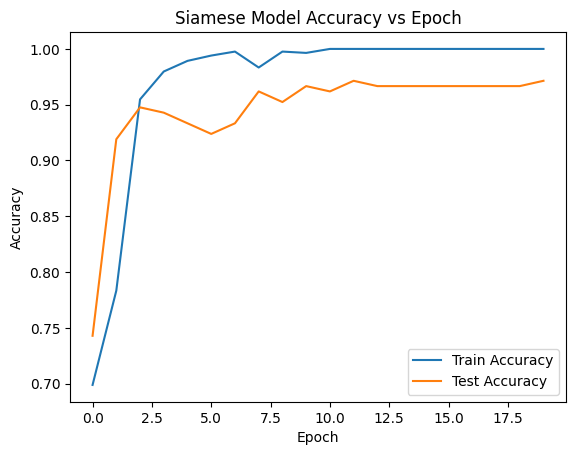

In [16]:
# --- Cell 6 (Siamese Evaluation Plot) ---
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Siamese Model Accuracy vs Epoch')
plt.show()

In [18]:
# --- Cell 7 (Siamese Prediction Example) ---
def predict_pair(sig1, sig2):
    img1 = np.expand_dims(sig1.resampled, axis=(0, -1))
    img2 = np.expand_dims(sig2.resampled, axis=(0, -1))
    prob = siamese_model.predict([img1, img2], verbose=0)[0][0]
    return prob, "Same (Genuine)" if prob > 0.5 else "Different (Forged)"

Prediction Strength = 0.000, Prediction = Different (Forged)


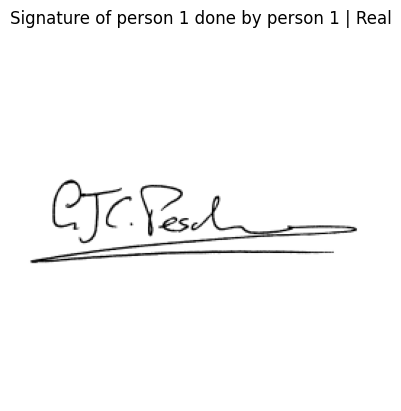

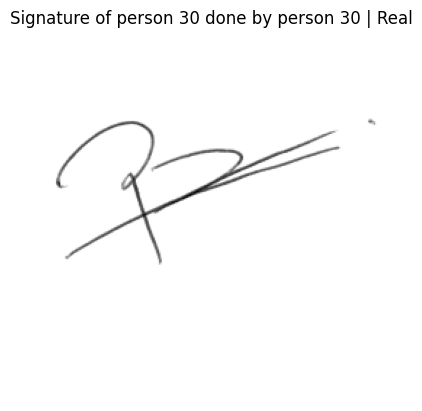

In [19]:
# Example usage
sig1 = all_data.signatures[0]  # genuine
sig2 = all_data.signatures[65] # possibly forged
prob, label = predict_pair(sig1, sig2)
print(f"Prediction Strength = {prob:.3f}, Prediction = {label}")
sig1.show_signature()
sig2.show_signature()

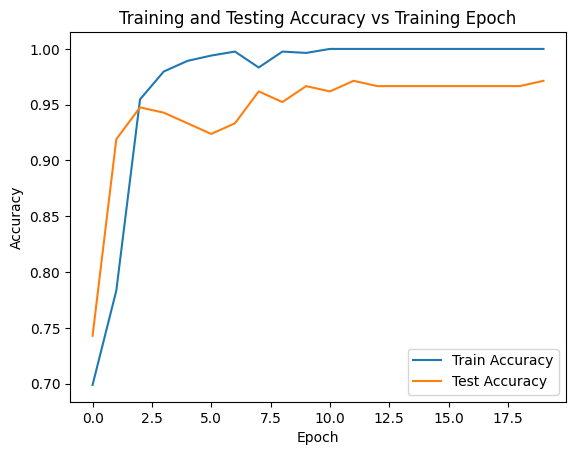

In [20]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Testing Accuracy vs Training Epoch')
plt.show()

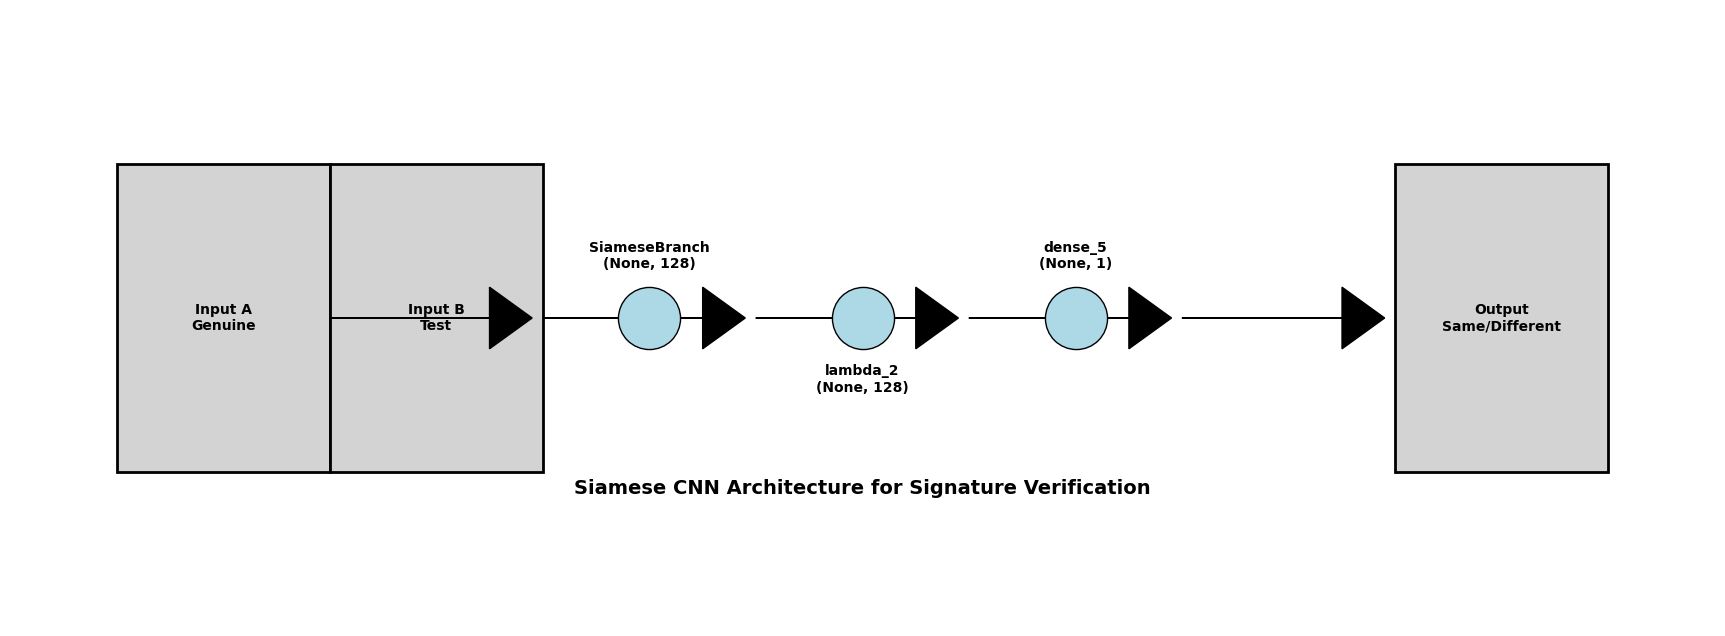

In [ ]:
# Visualize the architecture of the Siamese CNN model.
# This diagram shows the dual input branches (genuine and test signatures),
# the shared convolutional encoder (SiameseBranch), the L1 distance computation via Lambda layer,
# and the final dense layer that outputs the similarity score. 
def plot_siamese_architecture(model):
    import matplotlib.pyplot as plt

    # Get layer names and shapes safely
    layers = []
    for layer in model.layers:
        if "input" not in layer.name.lower():
            try:
                output_shape = tuple(layer.output.shape)
            except AttributeError:
                output_shape = "(?)"
            layers.append((layer.name, output_shape))

    fig, ax = plt.subplots(figsize=(22, 8))
    x_positions = range(len(layers) + 3)
    y_position = 0

    # Two input blocks
    ax.add_patch(plt.Rectangle((-0.5, y_position - 0.5), 1, 1, color="lightgray", ec="black", lw=2))
    ax.text(0, y_position, "Input A\nGenuine", ha="center", va="center", fontsize=10, fontweight="bold")

    ax.add_patch(plt.Rectangle((0.5, y_position - 0.5), 1, 1, color="lightgray", ec="black", lw=2))
    ax.text(1, y_position, "Input B\nTest", ha="center", va="center", fontsize=10, fontweight="bold")

    # Shared feature extraction
    for i, (layer_name, shape) in enumerate(layers):
        x_pos = i + 2
        shape_str = str(shape)
        ax.scatter(x_pos, y_position, s=2000, color="lightblue", edgecolors="black", zorder=2)
        ax.text(x_pos, y_position + (0.2 if i % 2 == 0 else -0.2), f"{layer_name}\n{shape_str}",
                ha="center", va="center", fontsize=10, fontweight="bold")

    # Output block
    output_x = len(layers) + 2
    ax.add_patch(plt.Rectangle((output_x + 0.5, y_position - 0.5), 1, 1, color="lightgray", ec="black", lw=2))
    ax.text(output_x + 1, y_position, "Output\nSame/Different", ha="center", va="center", fontsize=10, fontweight="bold")

    # Arrows between components
    for i in range(len(layers) + 2):
        ax.arrow(x_positions[i] + 0.5, y_position, 0.75, 0, head_width=0.2, head_length=0.2, fc="black", ec="black")

    ax.set_xlim(-1, len(layers) + 4)
    ax.set_ylim(-1, 1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_frame_on(False)
    plt.title("Siamese CNN Architecture for Signature Verification", fontsize=14, fontweight="bold", y=0.2)
    plt.show()

# Run the plot
plot_siamese_architecture(siamese_model)


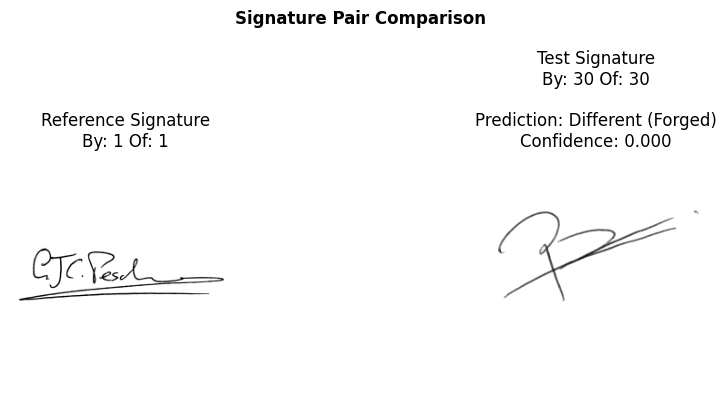

In [22]:
def show_signature_pair(sig1, sig2, prob, label):
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))
    axs[0].imshow(sig1.resampled, cmap='gray')
    axs[0].set_title(f"Reference Signature\nBy: {sig1.signature_by} Of: {sig1.signature_of}")
    axs[0].axis('off')

    axs[1].imshow(sig2.resampled, cmap='gray')
    axs[1].set_title(f"Test Signature\nBy: {sig2.signature_by} Of: {sig2.signature_of}\n\nPrediction: {label}\nConfidence: {prob:.3f}")
    axs[1].axis('off')
    plt.suptitle("Signature Pair Comparison", fontsize=12, fontweight="bold")
    plt.tight_layout()
    plt.show()

# Example
sig1 = all_data.signatures[0]
sig2 = all_data.signatures[65]
prob, label = predict_pair(sig1, sig2)
show_signature_pair(sig1, sig2, prob, label)


/tmp/ipykernel_3332271/1431487336.py:18: RuntimeWarning: divide by zero encountered in divide
  matrix = np.where(matrix_count != 0, matrix / matrix_count, -1)


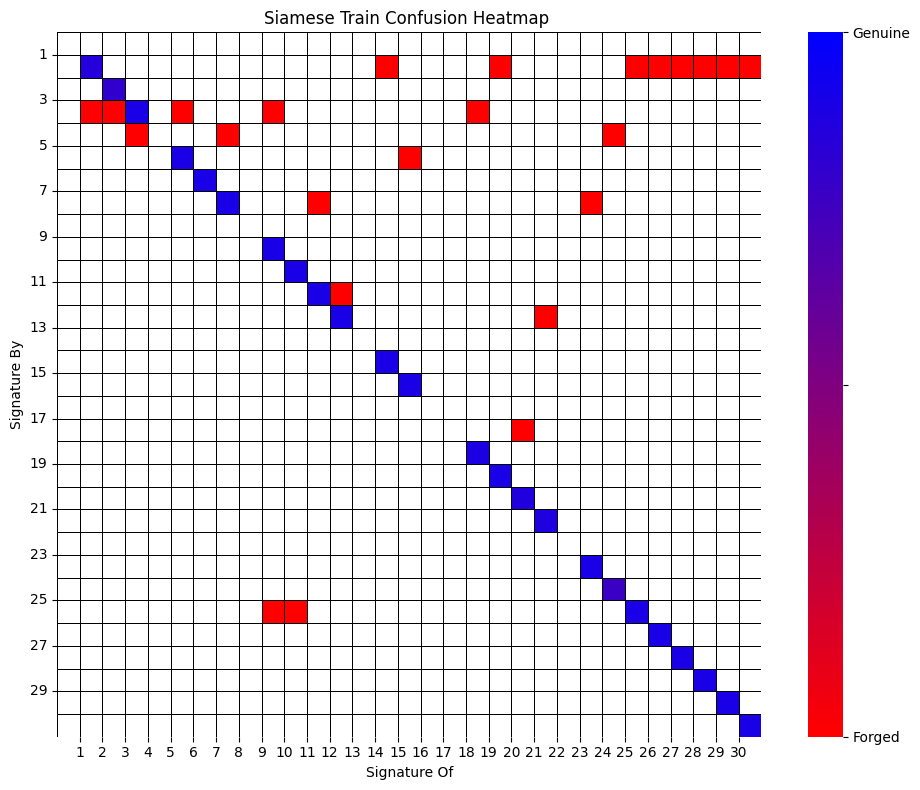

/tmp/ipykernel_3332271/1431487336.py:18: RuntimeWarning: divide by zero encountered in divide
  matrix = np.where(matrix_count != 0, matrix / matrix_count, -1)


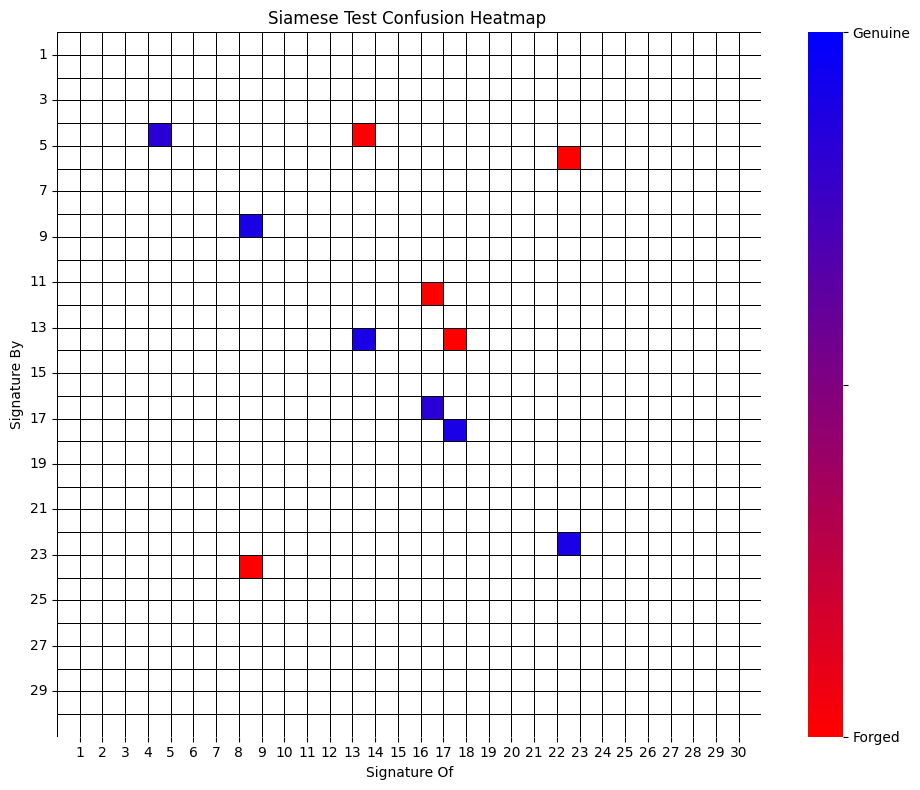

In [28]:
#  Siamese Heatmap  

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

def plot_siamese_filtered_heatmap(sig_by, sig_of, predictions, title, max_id=30):
    matrix = np.full((max_id + 1, max_id + 1), -1.0)
    matrix_count = np.zeros((max_id + 1, max_id + 1))

    for s1, s2, pred in zip(sig_by, sig_of, predictions):
        if s1 <= max_id and s2 <= max_id:
            matrix[s1, s2] += pred
            matrix_count[s1, s2] += 1

    with np.errstate(invalid='ignore'):
        matrix = np.where(matrix_count != 0, matrix / matrix_count, -1)

    plt.figure(figsize=(10, 8))
    mask = matrix == -1
    cmap = LinearSegmentedColormap.from_list("blue_red", ["red", "purple", "blue"])
    ax = sns.heatmap(matrix, cmap=cmap, cbar=True, vmin=0, vmax=1, mask=mask,
                     linewidths=0.5, linecolor='black', square=True)

    ax.set_xlabel("Signature Of")
    ax.set_ylabel("Signature By")
    ax.set_xticks(np.arange(1, max_id + 1))
    ax.set_xticklabels(np.arange(1, max_id + 1))
    ax.set_yticks(np.arange(1, max_id + 1, 2))
    ax.set_yticklabels(np.arange(1, max_id + 1, 2), rotation=0)

    cbar = ax.collections[0].colorbar
    cbar.set_ticks([0, 0.5, 1])
    cbar.set_ticklabels(["Forged", "", "Genuine"])

    plt.title(title)
    plt.tight_layout()
    plt.show()

#  Apply to cleaned predictions

plot_siamese_filtered_heatmap(sig_by_train_pred, sig_of_train_pred, train_preds, "Siamese Train Confusion Heatmap ")
plot_siamese_filtered_heatmap(sig_by_test_pred, sig_of_test_pred, test_preds, "Siamese Test Confusion Heatmap ")
